# Import Libraries

In [ ]:
import torch
import numpy as np
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt

# PyTorch Implementation

In [ ]:
def projected_gradient_descent(x_sample, y_sample, model, epsilon=0.1, alpha=0.01, num_iterations=40, norm='L_inf'):
    x_adv = torch.tensor(x_sample, requires_grad=True)
    y_sample = torch.tensor(y_sample)

    for i in range(num_iterations):
        model.zero_grad()
        predictions = model(x_adv)
        loss = F.cross_entropy(predictions, y_sample)
        loss.backward()

        gradient = x_adv.grad.data

        if norm == "L_inf":
            signed_grad = torch.sign(gradient)
            x_adv = x_adv + alpha * signed_grad
            x_adv = torch.clamp(x_adv, x_sample - epsilon, x_sample + epsilon)

        elif norm == "L_1":
            grad_norm = torch.sum(torch.abs(gradient), dim=[1, 2, 3], keepdim=True)
            normalized_grad = gradient / (grad_norm + 1e-10)
            x_adv = x_adv + alpha * normalized_grad

            perturbation = x_adv - x_sample
            perturb_norm = torch.sum(torch.abs(perturbation), dim=[1, 2, 3], keepdim=True)
            scaling_factor = torch.minimum(torch.tensor(1.0), epsilon / (perturb_norm + 1e-10))
            x_adv = x_sample + perturbation * scaling_factor

        elif norm == "L_2":
            grad_norm = torch.sqrt(torch.sum(torch.square(gradient), dim=[1, 2, 3], keepdim=True))
            normalized_grad = gradient / (grad_norm + 1e-10)
            x_adv = x_adv + alpha * normalized_grad

            perturbation = x_adv - x_sample
            perturb_norm = torch.sqrt(torch.sum(torch.square(perturbation), dim=[1, 2, 3], keepdim=True))
            scaling_factor = torch.minimum(torch.tensor(1.0), epsilon / (perturb_norm + 1e-10))
            x_adv = x_sample + perturbation * scaling_factor

        x_adv = x_adv.detach().requires_grad_(True)

    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return x_adv.detach().numpy()

# TensorFlow Implementation

In [41]:
def projected_gradient_descent(x_sample, y_sample, epsilon=0.1, alpha=0.01, num_iterations=40, norm='L_inf'):
    x_adv = tf.convert_to_tensor(x_sample)
    y_sample = tf.convert_to_tensor(y_sample)

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            predictions = model(x_adv)
            loss = tf.keras.losses.categorical_crossentropy(y_sample, predictions)

        gradient = tape.gradient(loss, x_adv)

        if norm == "L_inf":
            signed_grad = tf.sign(gradient)
            x_adv = x_adv + alpha * signed_grad
            x_adv = tf.clip_by_value(x_adv, x_sample - epsilon, x_sample + epsilon)

        elif norm == "L_1":
            grad_norm = tf.reduce_sum(tf.abs(gradient), axis=[1, 2, 3], keepdims=True)
            normalized_grad = gradient / (grad_norm + 1e-10)
            x_adv = x_adv + alpha * normalized_grad

            perturbation = x_adv - x_sample
            perturb_norm = tf.reduce_sum(tf.abs(perturbation), axis=[1, 2, 3], keepdims=True)
            scaling_factor = tf.minimum(1.0, epsilon / (perturb_norm + 1e-10))
            x_adv = x_sample + perturbation * scaling_factor
        
        elif norm == "L_2":
            grad_norm = tf.sqrt(tf.reduce_sum(tf.square(gradient), axis=[1, 2, 3], keepdims=True))
            normalized_grad = gradient / (grad_norm + 1e-10)
            x_adv = x_adv + alpha * normalized_grad

            perturbation = x_adv - x_sample
            perturb_norm = tf.sqrt(tf.reduce_sum(tf.square(perturbation), axis=[1, 2, 3], keepdims=True))
            scaling_factor = tf.minimum(1.0, epsilon / (perturb_norm + 1e-10))
            x_adv = x_sample + perturbation * scaling_factor

    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv.numpy()

# Load Data

In [42]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [43]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [44]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Load Model

In [45]:
model = tf.keras.models.load_model("models/cifar10_safe_model.h5")

# Attack

In [46]:
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer",
                       "dog", "frog", "horse", "ship", "truck"]

In [71]:
idx = 1
x_sample = x_test[idx:idx+1]
y_sample = y_test[idx:idx+1]

In [81]:
perturbed_sample = projected_gradient_descent(x_sample, y_sample, epsilon=0.3, alpha=0.05, num_iterations=50, norm='L_2')

In [82]:
original_image = x_sample[0, :, :, :]
perturbed_image = perturbed_sample[0, :, :, :]

In [83]:
original_pred = np.argmax(model.predict(x_sample, verbose=False), axis=1)
perturbed_pred = np.argmax(model.predict(perturbed_sample, verbose=False), axis=1)

print(f"Prediction before attack: {original_pred}")
print(f"Prediction after attack: {perturbed_pred}")

Prediction before attack: [8]
Prediction after attack: [1]


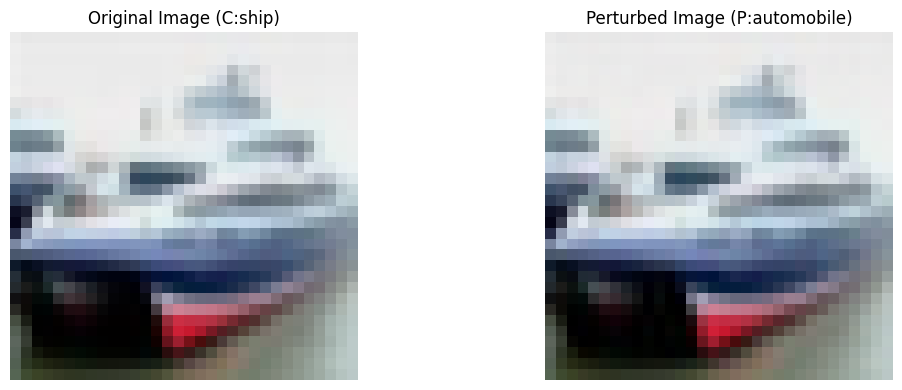

In [84]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title(f"Original Image (C:{cifar10_class_names[original_pred[0]]})")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Perturbed Image (P:{cifar10_class_names[perturbed_pred[0]]})")
plt.imshow(perturbed_image)
plt.axis("off")

plt.tight_layout()
plt.show()